# Tutorial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
import sys, os
# Get the current script’s directory
current_directory = os.getcwd()
# Go back one folder level
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
sys.path.insert(0, parent_directory)
from mtsthelens import preprocessing_functions, manipulation_functions, plotting_functions

## Read & preprocess data

In [3]:
# Read input data
raw_data =  preprocessing_functions.read_data('../example/example_data/example_data_eruption.csv')

# Data smoothing
raw_data = raw_data.rolling('6H', center=True).median()

# Remove outliers
raw_data = raw_data.apply(preprocessing_functions.mask_df,axis=0) # peak detection
raw_data

time
2004-01-01 00:00:00    1.180261
2004-01-01 00:10:00    1.185823
2004-01-01 00:20:00    1.188123
2004-01-01 00:30:00    1.190423
2004-01-01 00:40:00    1.214803
                         ...   
2005-12-31 23:10:00    1.333559
2005-12-31 23:20:00    1.326346
2005-12-31 23:30:00    1.319133
2005-12-31 23:40:00    1.317940
2005-12-31 23:50:00    1.316746
Name: HSR, Length: 105264, dtype: float64 could not be masked.
time
2004-01-01 00:00:00    0.724351
2004-01-01 00:10:00    0.729078
2004-01-01 00:20:00    0.737474
2004-01-01 00:30:00    0.745870
2004-01-01 00:40:00    0.749927
                         ...   
2005-12-31 23:10:00    2.603774
2005-12-31 23:20:00    2.596629
2005-12-31 23:30:00    2.603774
2005-12-31 23:40:00    2.596629
2005-12-31 23:50:00    2.589483
Name: STD, Length: 105264, dtype: float64 could not be masked.


,HSR,STD
time,,
2004-01-01 00:00:00,1.180261,0.724351
2004-01-01 00:10:00,1.185823,0.729078
2004-01-01 00:20:00,1.188123,0.737474
2004-01-01 00:30:00,1.190423,0.745870
2004-01-01 00:40:00,1.214803,0.749927
...,...,...
2005-12-31 23:10:00,1.333559,2.603774
2005-12-31 23:20:00,1.326346,2.596629
2005-12-31 23:30:00,1.319133,2.603774


## Data manipulation

### Stack in Time

In [4]:
# Find the seasonal trends in the data, and create a new dataframe with the seasonality removed
data_seasonal_trends, data_seasonality_removed = manipulation_functions.stack_in_time(raw_data)
data_seasonality_removed

,HSR,STD
time,,
2004-01-01 00:00:00,-0.456950,0.006014
2004-01-01 00:10:00,-0.453864,0.008377
2004-01-01 00:20:00,-0.452714,0.012576
2004-01-01 00:30:00,-0.451564,0.016774
2004-01-01 00:40:00,-0.438844,0.018802
...,...,...
2005-12-31 23:10:00,-0.378525,0.965686
2005-12-31 23:20:00,-0.382132,0.958235
2005-12-31 23:30:00,-0.387096,0.953627


### Stack in Space

In [5]:
# Find the differences between the stations, and the average 
data_median_stackspace, data_stackspace_year = manipulation_functions.stack_in_space(raw_data)
data_yearly_params = manipulation_functions.stack_space_year_param(data_stackspace_year)
data_yearly_params

,2004,2005
max,2.832102,2.491375
min,0.530687,0.656356
mean,1.274495,1.290980
median,1.185799,1.212964


### Apply Filter

,HSR,STD
time,,
2004-01-01 00:00:00,1.439285e-13,8.833189e-14
2004-01-01 00:10:00,1.581453e-12,9.707306e-13
2004-01-01 00:20:00,8.758122e-12,5.377653e-12
2004-01-01 00:30:00,3.311431e-11,2.034289e-11
2004-01-01 00:40:00,9.745464e-11,5.990656e-11
...,...,...
2005-12-31 23:10:00,1.541188e+00,1.988222e+00
2005-12-31 23:20:00,1.541602e+00,1.990878e+00
2005-12-31 23:30:00,1.542015e+00,1.993528e+00


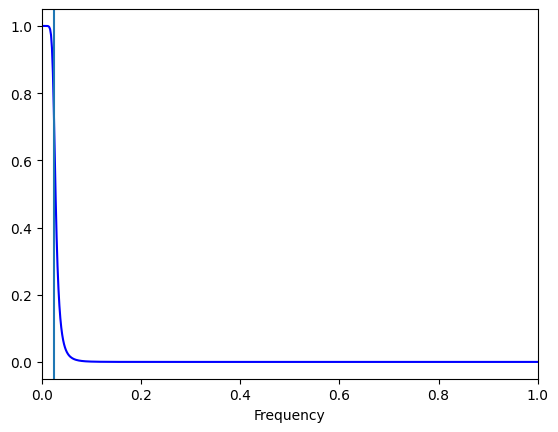

In [6]:
raw_data = raw_data.fillna(0)
data_filtered = manipulation_functions.filter_data(raw_data)
data_filtered

## Data plotting

In [7]:
# read extrusion rate data
extrusion_data = pd.read_csv('../example/example_data/dome_extrusion.txt', header=0, skiprows=0)
extrusion_data.set_index('Date of photography',inplace=True)
extrusion_data.index = pd.to_datetime(extrusion_data.index).tz_localize(None)
extrusion_data.head()

,Total volume change(x 106 m3),Total volume change rate (m3/s),Extruded lava volume (x 106 m3),Lava extrusion rate (m3/s)
Date of photography,,,,
2004-09-23,0,NaN,NaN,NaN
2004-10-04,5,NaN,NaN,NaN
2004-10-11,10,8.9,NaN,NaN
2004-10-13,11,6.4,0.54,NaN
2004-11-04,20,4.6,12.00,5.9


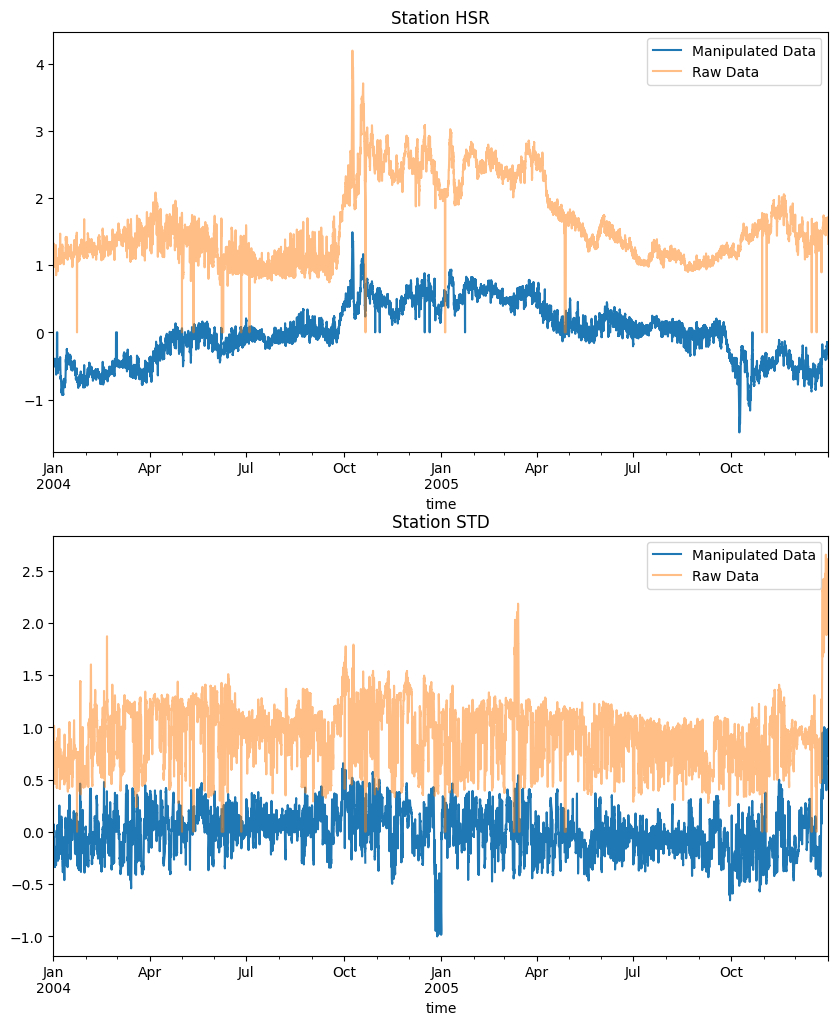

In [8]:
# Plotting Time Stack vs Raw Data
plotting_functions.plot_stack_vs_raw(data_seasonality_removed, raw_data)

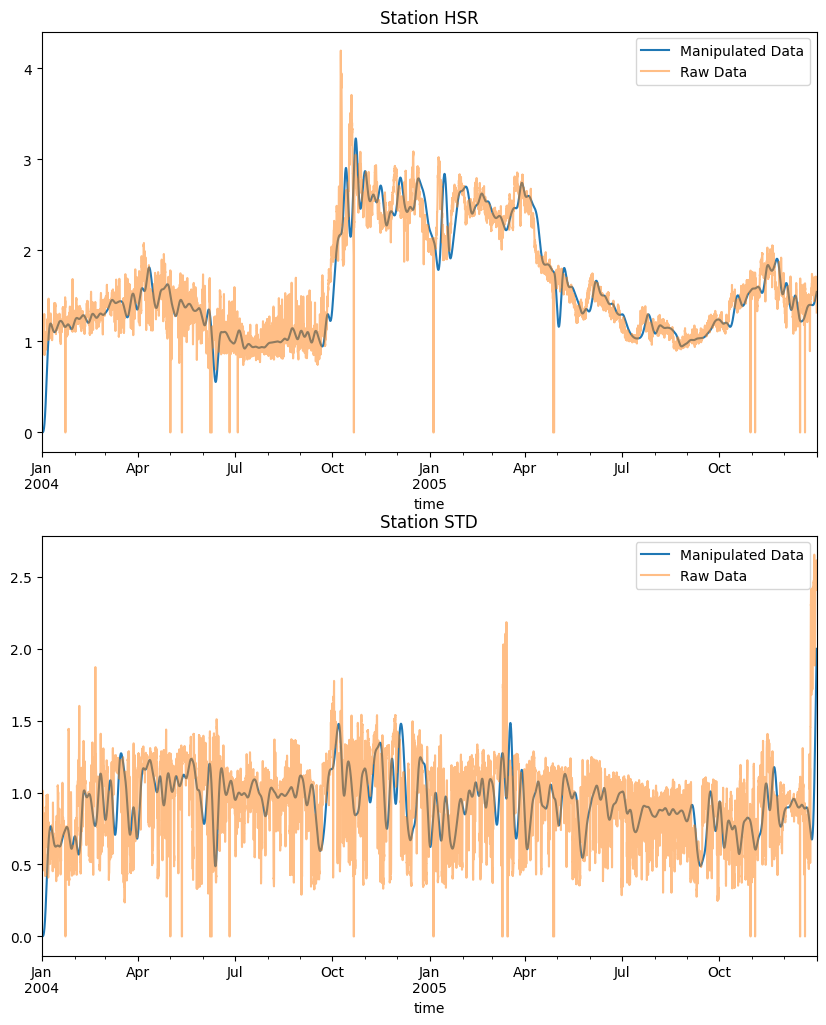

In [9]:
# Plotting Filtered Timestack vs Raw Data
plotting_functions.plot_stack_vs_raw(data_filtered, raw_data)

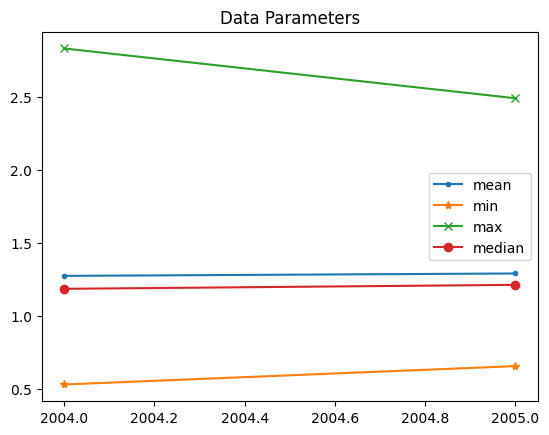

In [10]:
# Plotting the Yearly parameters of the Space Stack
plotting_functions.plot_space_params(data_yearly_params)

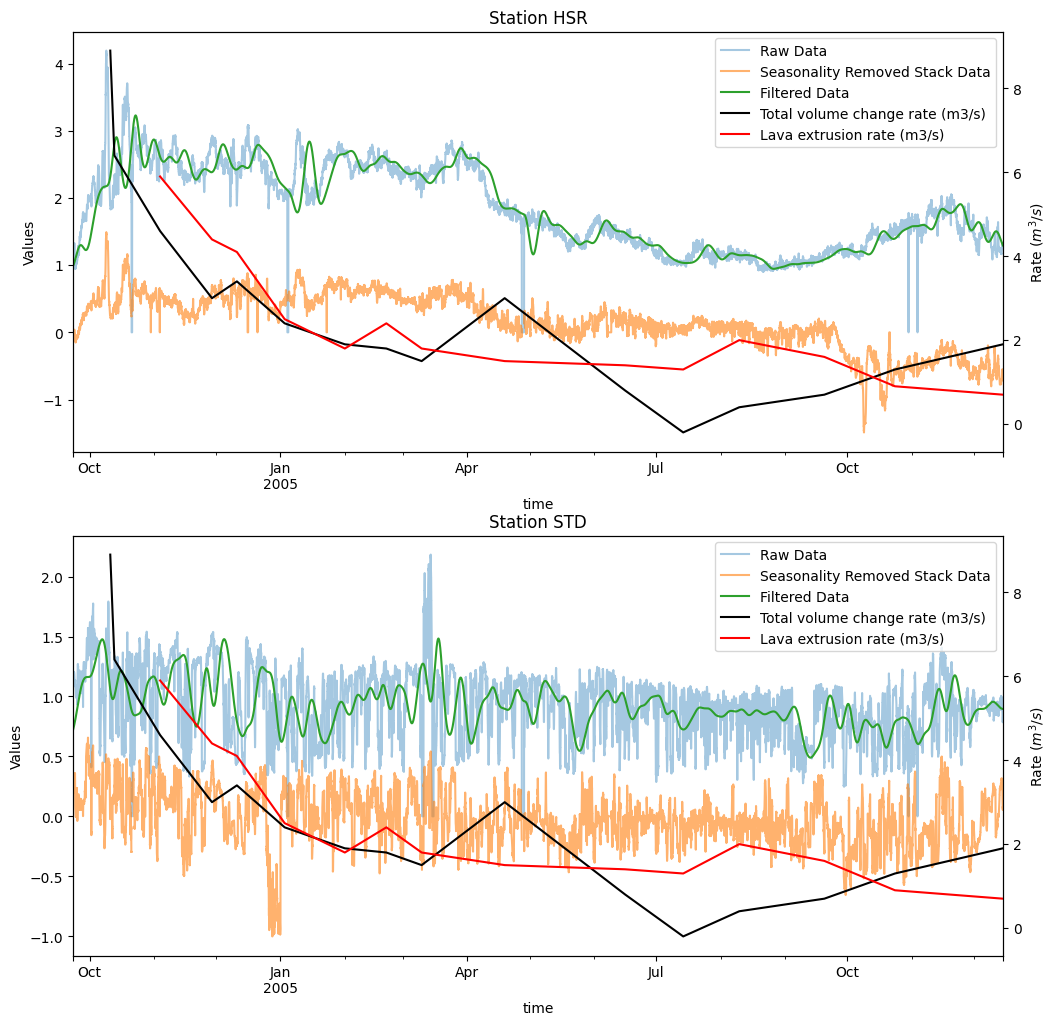

In [11]:
# Plotting the extrusion rates and comparing with Raw, Seasonality Removed and Filtered Data
plotting_functions.plot_extrusion(extrusion_data, raw_data, data_seasonality_removed, data_filtered)

### Bring data into used shape

In [12]:
# load station coordinates and drop the stations which are not of interresst
sta_list =['BLIS', 'CDF', 'EDM', 'ELK', 'FL2', 'HOA', 'HSR', 'JRO', 'JUN', # specify the stations you want to use
           'LOO', 'MIDE', 'NED', 'RAFT', 'REM', 'SEP', 'SHW', 'SOS', 'SPN5',
           'STD', 'SUG', 'SWFL', 'TDL', 'USFR', 'VALT', 'YEL'] 

df_sta = pd.read_csv('./example_data/sta_log_long.txt', sep='|', header=0) # coordinates
df_sta = df_sta[~df_sta['Station'].isin(list(set(df_sta.Station)-set(sta_list)))] # delete Stations which are not of interresst
df_sta = df_sta.drop_duplicates(subset=['Station']) # drop one station if the station is not unique
df_sta = df_sta.reset_index(drop=True)
df_sta.head()

,Network,Station,latitude,longitude,Elevation,Sitename,StartTime,EndTime
0,CC,BLIS,46.197472,-122.186569,2116.00,"Blister, Mt. St. Helens (Dome sta)",2004-10-12T00:00:00,2005-02-17T00:00:00
1,CC,HOA,46.241780,-122.191830,1151.00,Hoala,2021-06-08T00:00:00,2599-12-31T23:59:59
2,CC,JRO,46.275270,-122.218260,1219.00,Johnston Ridge Observatory,2004-10-02T00:00:00,2599-12-31T23:59:59
3,CC,LOO,46.223750,-122.184390,1521.35,Loowit,2021-06-08T00:00:00,2599-12-31T23:59:59
4,CC,MIDE,46.197750,-122.187439,2132.00,Near old BLIS MSH,2005-02-16T00:00:00,2005-07-26T00:00:00


In [13]:
df_stat = manipulation_functions.stack_space_year_param(raw_data) # extract statistical values

# append latitude and longitude of the station as rows for plotting
df_stat.loc['latitude'] = [df_sta.loc[df_sta['Station'] == sta, 'latitude'].values[0] for sta in df_stat.columns]
df_stat.loc['longitude'] = [df_sta.loc[df_sta['Station'] == sta, 'longitude'].values[0] for sta in df_stat.columns]
df_stat

,HSR,STD
max,4.194300,2.653408
min,0.000000,0.000000
mean,1.602863,0.940644
median,1.434485,0.982921
latitude,46.174280,46.237490
longitude,-122.180650,-122.224210


In [14]:
# Create a dictionary with Date as key for, DataFrames
dict_test = manipulation_functions.df2dict(raw_data, 'year')
dict_stat = {}
for key, value in dict_test.items():
    df_stat = manipulation_functions.stack_space_year_param(value) # extract statistical values

    # append latitude and longitude of the station as rows for plotting
    df_stat.loc['latitude'] = [df_sta.loc[df_sta['Station'] == sta, 'latitude'].values[0] for sta in df_stat.columns]
    df_stat.loc['longitude'] = [df_sta.loc[df_sta['Station'] == sta, 'longitude'].values[0] for sta in df_stat.columns]
    dict_stat[key] = df_stat

# Save the dictionary as npy
np.save('./output/data/my_file.npy', dict_stat) 

### Create Plots for Animation

In [15]:
stations_data = np.load('./output/data/my_file.npy',allow_pickle='TRUE').item()
stations_data

{2004:                   HSR         STD
 max          4.194300    1.871617
 min          0.000000    0.000000
 mean         1.548180    0.980650
 median       1.339965    1.052015
 latitude    46.174280   46.237490
 longitude -122.180650 -122.224210,
 2005:                   HSR         STD
 max          3.024086    2.653408
 min          0.000000    0.000000
 mean         1.657696    0.900529
 median       1.513317    0.930664
 latitude    46.174280   46.237490
 longitude -122.180650 -122.224210}

In [16]:
plotting_functions.animation(stations_data, 'median', 'inferno')

### Plot Station sorted by distance

This part of the project is still in progress. The example date should produce an output but we did not wrote the final functions and tests for this part.

In [ ]:
# get the distance between the stations and sort them in increasing order (relative to station SEP -> crater center)
ref_sta = 'SEP' # define the reference station, we will get distance from all other stations to this station
df_sta['dist'] = df_sta.apply(lambda x: preprocessing_functions.calculate_distance(x['latitude'],df_sta.latitude[df_sta['Station']==ref_sta].values[0] , x['longitude'],df_sta.longitude[df_sta['Station']==ref_sta].values[0] ), axis=1)
df_sta = df_sta.sort_values(by=['dist'])
sta_sorted = df_sta['Station'].to_list()
df_sta.head()

In [ ]:
df = raw_data.copy()
# sort the columns corresponding to crater distane
def sort_columns(df, column_order):
    # Filter the list to only include existing columns in the DataFrame
    valid_columns = [col for col in column_order if col in df.columns]

    # Sort the DataFrame columns based on the valid columns list
    sorted_columns = valid_columns + [col for col in df.columns if col not in valid_columns]

    # Return the DataFrame with sorted columns
    return df[sorted_columns]

# column names and drop too short stations
# value = df.rename(columns={"YEL/VALT": "YEL"})
# value = df.drop(['NED','JRO'], axis=1)

# resample
df = df.resample('1D').median()

# resample
df = df.rolling('2D', center=True).median()

# Sort the columns based on the desired order
df_sorted = sort_columns(df, sta_sorted)

# Display the result
df_sorted

In [ ]:
 # Normalize the columns
df_sorted_norm = df_sorted.apply(preprocessing_functions.norm, axis=0)

# Display the result
df_sorted_norm

In [ ]:
# read txt-file with UTC times and type of activity
df_activity = pd.read_csv('./example_data/mt_st_helens_activity.txt', header=1, skiprows=11)
df_activity.set_index('UTC',inplace=True)
df_activity.index = pd.to_datetime(df_activity.index).tz_localize(None)

activity_dome = df_activity.copy()
activity_dome_start = activity_dome[activity_dome['activity' ]=='d'].take([0,2,3,4,5,6])
activity_dome_end = activity_dome[activity_dome['activity' ]=='ed'].take([1,2,3,4,5,6])
activity_dome_start, activity_dome_end

In [ ]:
from matplotlib.pyplot import cm
# Plot each column with an offset along the y-axis
year_plot = [2004, 2005]

fig, ax = plt.subplots(figsize=(6.4*2, 4.8))
offset = 0

for col in df_sorted_norm.columns:
    y_values = df_sorted_norm[col] + offset
    ax.plot(df_sorted_norm.index, y_values, label=col)
    offset += 0.5  # Adjust the offset as needed

ax.set_yticks(np.arange(0.25,(len(df_sorted_norm.columns))/2,0.5))
ax.set_yticklabels(df_sorted_norm.columns)
    
plt.xlim([datetime.datetime(year_plot[0],1,1), datetime.datetime(year_plot[-1],1,1)])

color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

for i in range(len(activity_dome_start)):
    sdate = activity_dome_start.index[i].to_pydatetime() # start date
    edate = activity_dome_end.index[i].to_pydatetime() # end date
    ax.axvspan(sdate, edate, alpha=0.25, color=color[i])
    
plt.title('DSAR')
# plt.savefig('output_path', dpi=300, bbox_inches='tight')
plt.show()